# rattlers - Stlr features
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Jan 24, 2022

## Hypothesis
The goal of this notebook is to compare the results of the model with the model using standard StellarAlgo features with the engineered retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 24 # rattlers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(5134, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134 entries, 0 to 5133
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   lkupClientId            5134 non-null   int64  
 1   dimCustomerMasterId     5134 non-null   int64  
 2   customerNumber          5134 non-null   object 
 3   year                    5134 non-null   int64  
 4   productGrouping         5134 non-null   object 
 5   totalSpent              5134 non-null   float64
 6   recentDate              5134 non-null   object 
 7   attendancePercent       5134 non-null   float64
 8   renewedBeforeDays       5134 non-null   int64  
 9   isBuyer                 5134 non-null   object 
 10  source_tenure           5134 non-null   int64  
 11  tenure                  5134 non-null   int64  
 12  distToVenue             5134 non-null   float64
 13  totalGames              5134 non-null   int64  
 14  recency                 5134 non-null   

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
                "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays",
                "isNextYear_Buyer",
                "productGrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3631, 13)
Unseen Data For Predictions: (641, 13)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "attendancePercent",
                "distToVenue",
                "missed_games_1",
                "missed_games_2",
                "missed_games_over_2",
                "totalSpent",
                "recency",
                "source_tenure",
                "renewedBeforeDays"
    ]
);

In [7]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7132,0.6623,0.8676,0.7617,0.8111,0.2257,0.2341,0.4070
lr,Logistic Regression,0.7080,0.6591,0.9635,0.7199,0.8240,0.0623,0.1000,0.3900


In [8]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7087,0.6660,0.8767,0.7529,0.8101,0.2003,0.2114
1,0.7508,0.7231,0.8904,0.7863,0.8351,0.3331,0.3442
2,0.7184,0.6422,0.8767,0.7619,0.8153,0.2355,0.2460
3,0.7249,0.6905,0.8813,0.7659,0.8195,0.2531,0.2644
4,0.6731,0.6535,0.8584,0.7287,0.7883,0.0925,0.0987
5,0.7152,0.6603,0.8539,0.7695,0.8095,0.2514,0.2568
6,0.7013,0.6348,0.8447,0.7613,0.8009,0.2099,0.2145
7,0.7045,0.6672,0.8676,0.7540,0.8068,0.1921,0.2009
8,0.7240,0.6548,0.8813,0.7659,0.8195,0.2454,0.2566
9,0.7110,0.6312,0.8447,0.7708,0.8061,0.2438,0.2478


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Py

### Let's load in our 2021 season data and get retention scores using the model:

In [9]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(415, 54)

In [10]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,education,urbanicity,credits_after_refund,is_Lockdown,NumberofGamesPerSeason,CNTPostponedGames,isNextYear_Buyer,Label,Score_0,Score_1
4719,24,320065317,185708,2021,Mini Plan,110.0,2021-08-15,0.416667,165,TRUE,...,0,0,0.0,1,132,0,0,0,0.7010,0.2990
4720,24,320066721,185318,2021,Mini Plan,108.0,2021-09-10,0.250000,-17,TRUE,...,0,0,0.0,1,132,0,1,0,0.5808,0.4192
4721,24,320067413,155562,2021,Mini Plan,72.0,2021-07-31,1.000000,249,TRUE,...,0,0,0.0,1,132,0,1,1,0.0497,0.9503
4722,24,320072078,727284,2021,Mini Plan,572.0,2021-09-10,0.840909,160,TRUE,...,0,0,0.0,1,132,0,0,1,0.1343,0.8657
4723,24,320074488,180851,2021,Mini Plan,10.0,2021-08-15,1.000000,258,TRUE,...,0,0,0.0,1,132,0,1,1,0.1438,0.8562


In [11]:
new_predictions["Label"].value_counts()

1    286
0    129
Name: Label, dtype: int64

In [12]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(0.8, 1.0]       148
(0.6, 0.8]       104
(0.4, 0.6]        76
(0.2, 0.4]        59
(-0.001, 0.2]     28
Name: Score_1, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

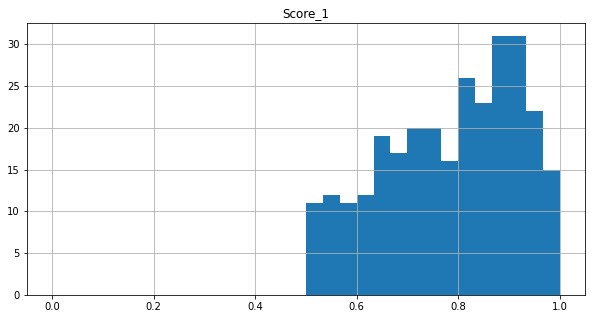

In [13]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

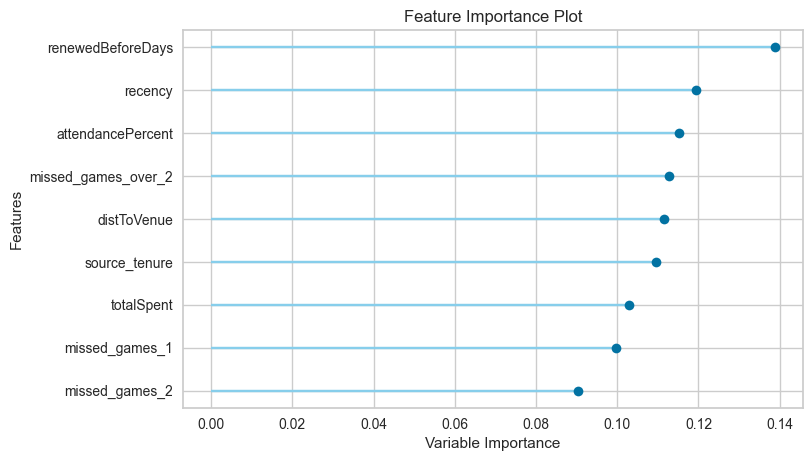

In [14]:
plot_model(best_model, plot='feature')

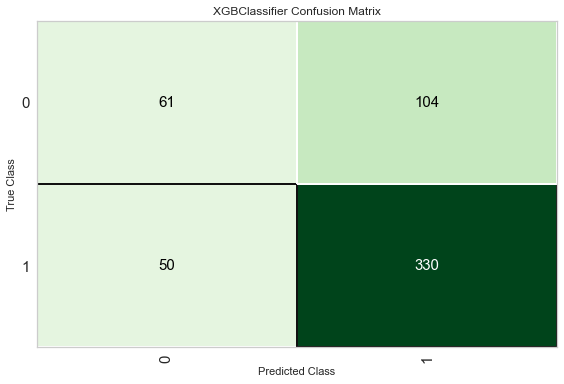

In [15]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

* the distribution doesn't look normal
* The ticketing data are in the top 3 feature importance
* The model makes more predictions of customers who won't buy
* The accuracy and the AUC decreased compared to using Full Season product

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?